## Importieren alle Bibliotheken, die im Code verwenden werden soll


In [1]:
# import die Datei- und Betriebssysteminteraktion Bibliotheken 
import os     # um das Datei, durch das Dateisystem zu navigieren                       
import time   # zum Messen von Zeit
import glob   # wird benutzt, um die Dateien enthaltenen Verzeichnissen in Dataframe auszudrucken
import shutil


import pathlib
import itertools
from PIL import Image

# Importiere Bibliotheken zur Datenverarbeitung
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#importieren Deep learning Bibliotheken
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


# Importieren, Auslesen der train-Daten und in Dataframe-Struktur ausdrucken

In [2]:
data_dir = '/kaggle/input/isic-2019/ISIC - 2019/train'

filepaths = glob.glob(os.path.join(data_dir, '*', '*'))
labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]

train_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [3]:
# Hier 2-col filepaths und labels
train_df

,filepaths,labels
0,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
1,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
2,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
3,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
4,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
...,...,...
21486,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21487,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21488,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21489,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma


## Importieren, Auslesen der test-Daten und in Dataframe-Struktur ausdrucken

In [4]:
data_dir = '/kaggle/input/isic-2019/ISIC - 2019/test'

test_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [5]:
# Hier 2-col filepaths und labels
test_df

,filepaths,labels
0,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
1,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
2,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
3,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
4,/kaggle/input/isic-2019/ISIC - 2019/train/Mela...,Melanoma
...,...,...
21486,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21487,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21488,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma
21489,/kaggle/input/isic-2019/ISIC - 2019/train/Derm...,Dermatofibroma


## Erstellung von Bild-data-Generator image 

In [6]:
# Definition von der Bildgröße und die Art von der Bildmodell hier ist RGB-modell
img_size = (64, 64)
channels = 3
img_shape = (*img_size, channels)

# ImageDataGenerator für training and testing
data_gen_params = dict(target_size=img_size, class_mode='categorical', color_mode='rgb', batch_size=512)  # hyperparamern
tr_gen = ImageDataGenerator() # für Training
ts_gen = ImageDataGenerator() # für Testing

# form der erstellten Dataframe training und testing
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', shuffle=True, **data_gen_params)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', shuffle=False, **data_gen_params)


Found 21491 validated image filenames belonging to 8 classes.
Found 21491 validated image filenames belonging to 8 classes.


## Anzeigen von jedem Klass in Train-Datei ein Bild, das max-Values in ihre Matrix repräsentiert

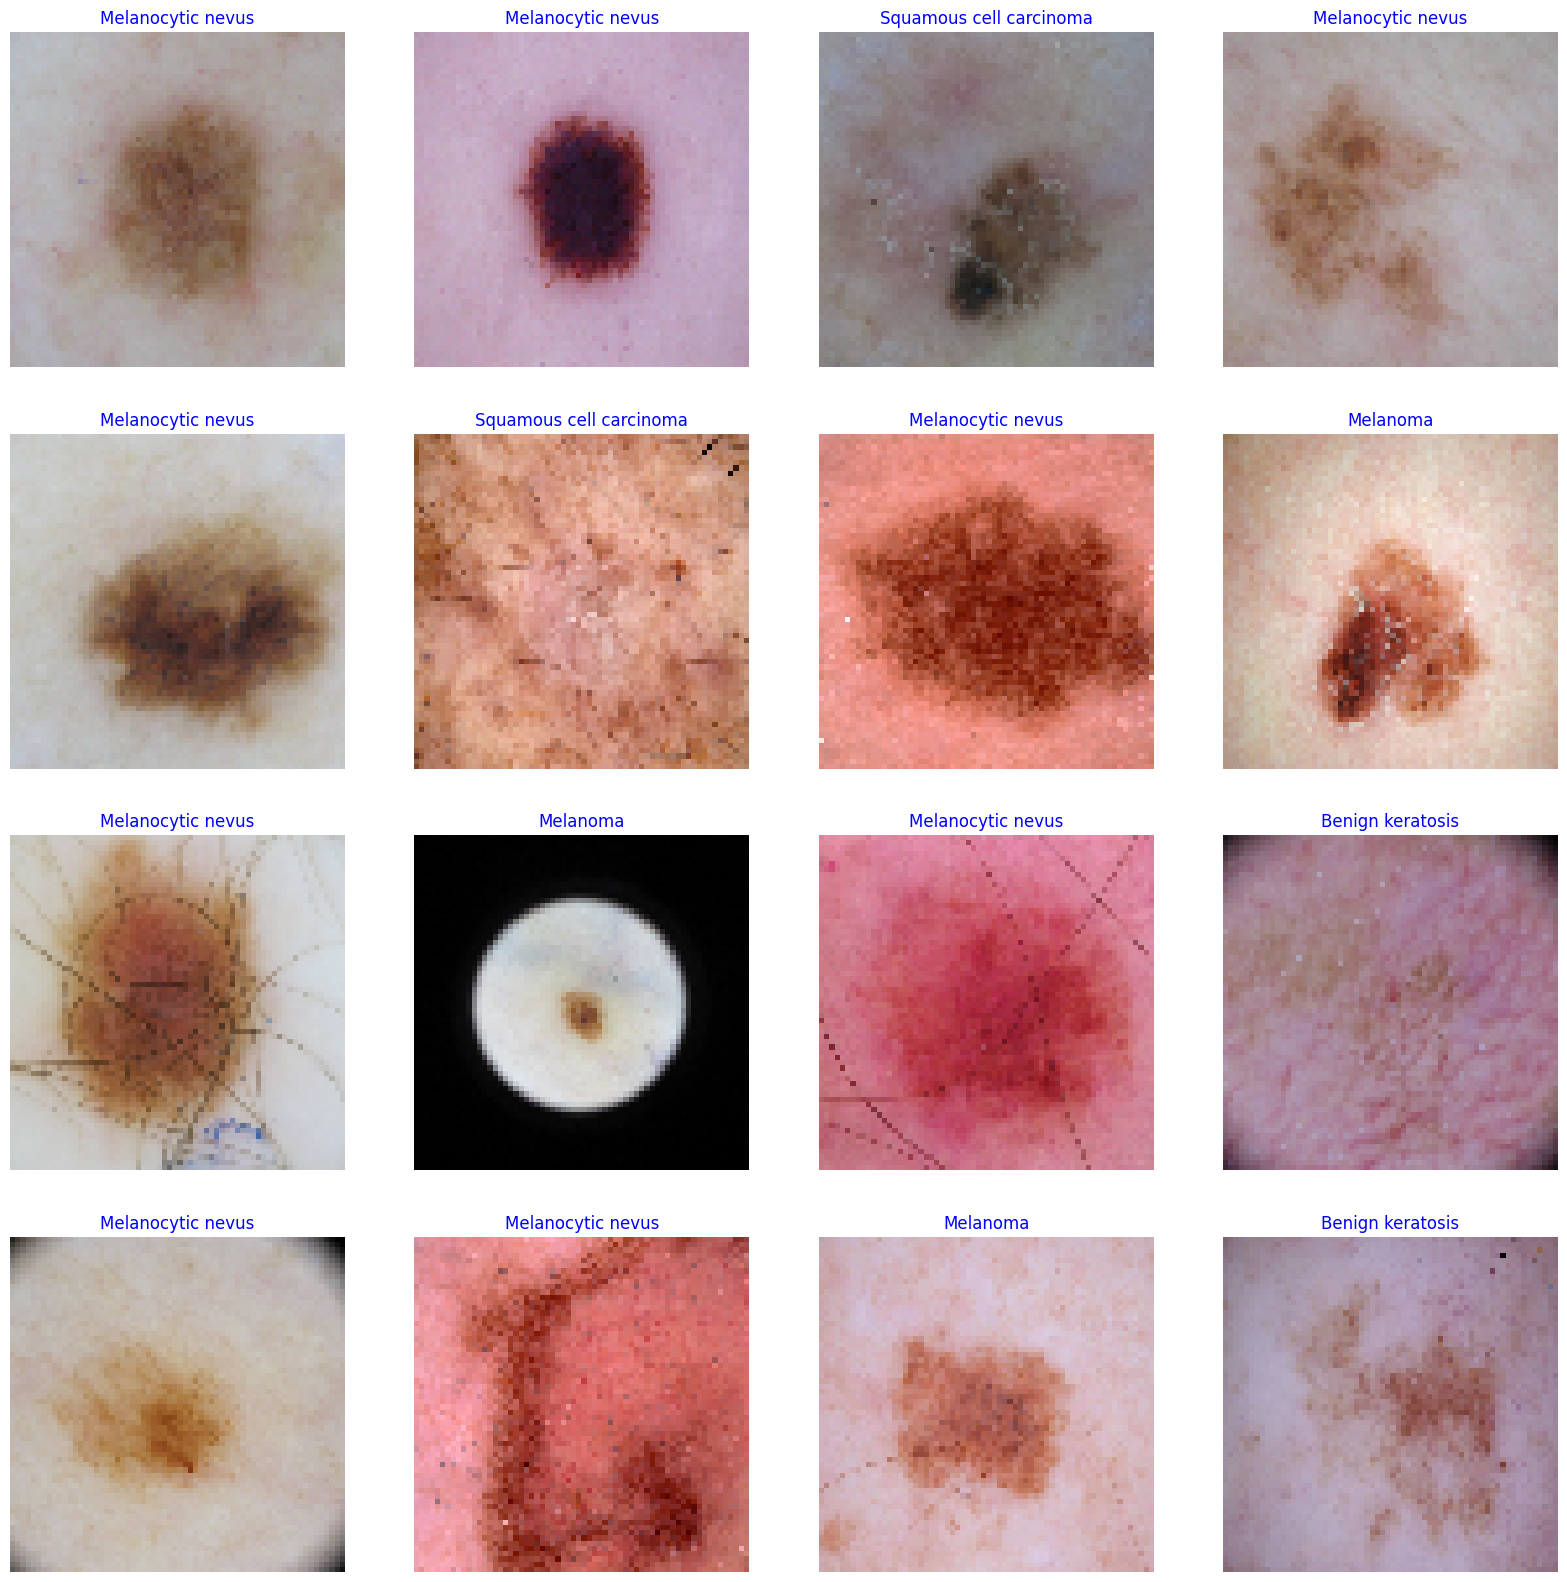

In [7]:
# Class Indices und Names bekommen:
class_indices = train_gen.class_indices
class_names = list(class_indices.keys())

# Batch von Bildern und Labels bekommen:
images, labels = next(train_gen)

# Matplotlib-Figure erstellen:
plt.figure(figsize=(20, 20))

# Bilder plotten:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    # Bilder normalisieren und anzeigen: in range [0, 1]
    image = images[i] / 255
    
    plt.imshow(image)
    
    # Klassenindex und -name für das Label extrahieren:
    index = np.argmax(labels[i])
    class_name = class_names[index]
    # Titel und Achseinstellungen für das Bild setzen:
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
# Plot anzeigen:
plt.show()

# Model Structure

## Erstellung des CNN (convolutional neuronales Netzwerk) basierend auf der Keras/EfficientNetB5-Architektur


In [8]:
# Modellparameter definieren:
img_size = (64, 64)
channels = 3
img_shape = (*img_size, channels)
class_count = len(train_gen.class_indices)   # to define number of classes in dense layer

# Vorab trainiertes Modell erstellen (EfficientNetB5) pre-trained model (EfficientNetB5):
base_model = tf.keras.applications.EfficientNetB5(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)
base_model.trainable = False

# Modell erstellen:
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer = regularizers.l1(0.006),
          bias_regularizer = regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Modell kompilieren:
model.compile(optimizer=Adamax(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modellzusammenfassung anzeigen mit summary() model
model.summary()


115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                       

### Train model

## Trainieren des Modells

In [9]:
# Unfreeze einiger Schichten für das Fine-Tuning:
base_model.trainable = True
fine_tune_at = 128
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Rekompilierung des Modells nach dem Unfreezing einiger Schichten:
model.compile(
    optimizer=Adamax(learning_rate=0.0001),  # Adjust the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Festlegen der Anzahl der Fine-Tuning-Epochen:
epochs_fine_tune = 32

# Trainieren des Modells mit den feinabgestimmten Schichten:
history_fine_tune = model.fit(
    x=train_gen,
    epochs=epochs_fine_tune,
    verbose=1,
    validation_data=test_gen,
    shuffle=False
)


Epoch 1/32


2023-12-28 21:07:49.634836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 556s 12s/step - loss: 10.2920 - accuracy: 0.2647 - val_loss: 8.9619 - val_accuracy: 0.5066
Epoch 2/32
42/42 [==============================] - 353s 8s/step - loss: 9.4461 - accuracy: 0.4275 - val_loss: 8.5482 - val_accuracy: 0.5488
Epoch 3/32
42/42 [==============================] - 359s 9s/step - loss: 8.9261 - accuracy: 0.4950 - val_loss: 8.3464 - val_accuracy: 0.5738
Epoch 4/32
42/42 [==============================] - 355s 9s/step - loss: 8.4096 - accuracy: 0.5371 - val_loss: 8.2535 - val_accuracy: 0.5957
Epoch 5/32
42/42 [==============================] - 356s 9s/step - loss: 7.9950 - accuracy: 0.5610 - val_loss: 7.8660 - val_accuracy: 0.6135
Epoch 6/32
42/42 [==============================] - 376s 9s/step - loss: 7.6564 - accuracy: 0.5782 - val_loss: 7.4838 - val_accuracy: 0.6278
Epoch 7/32
42/42 [==============================] - 360s 9s/step - loss: 7.3640 - accuracy: 0.5970 - val_loss: 7.1711 - val_accuracy: 0.6388
Epoch 8/32
42/42 [====

### Darstellung der Modellleistung

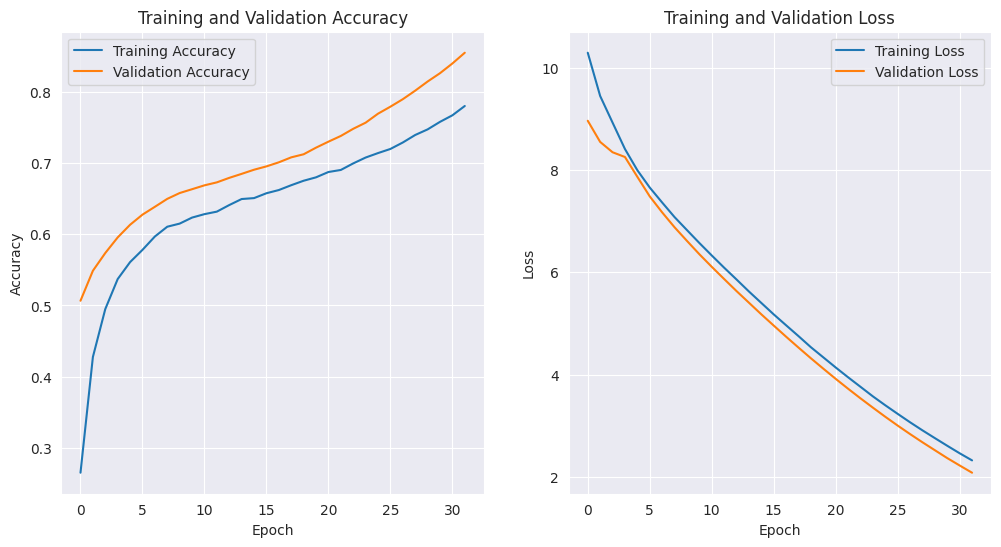

In [10]:
# Plotting-Bereich festlegen:
plt.figure(figsize=(12, 6))
# Subplots erstellen:
plt.subplot(1, 2, 1)
# Training und Validierung der Genauigkeit plotten:
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
# Diagrammtitel und Achsenbeschriftungen setzen:
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Legende hinzufügen:
plt.legend()

# Zweiten Subplot erstellen:
plt.subplot(1, 2, 2)
# Training und Validierung des Verlustes plotten:
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
# Diagrammtitel und Achsenbeschriftungen setzen:
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Diagramme anzeigen:
plt.show()


# Das Modell evaluieren

In [11]:
# Berechnung der Test-Batch-Größe und Schritte:
ts_length = len(test_df)
test_batch_size_candidates = [n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]
test_batch_size = max(test_batch_size_candidates)
test_steps = ts_length // test_batch_size

# Evaluation des Modells auf Trainings-, Validierungs- und Testsets:
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Anzeige der Auswertungsergebnisse:
print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print('-' * 40)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")


1/1 [==============================] - 5s 5s/step - loss: 2.1518 - accuracy: 0.8164
Train Loss: 2.052525520324707, Train Accuracy: 0.876953125
----------------------------------------
Test Loss: 2.1518044471740723, Test Accuracy: 0.81640625


# Vorhersagen erhalten

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

/tmp/ipykernel_26/2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


## Konfusion Matrix and Klassification Ergebnisse

42/42 [==============================] - 179s 4s/step


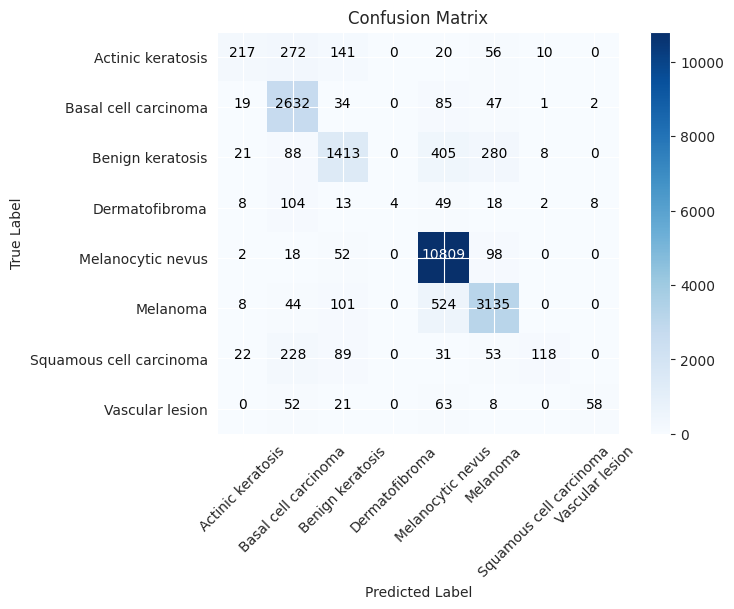

In [13]:
# Klassenindizes und -namen abrufen:
class_indices = test_gen.class_indices
classes = list(class_indices.keys())

# Verwirrungsmatrix berechnen
y_true = test_gen.classes
y_pred = model.predict(test_gen).argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Verwirrungsmatrix plotten:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
# Achsenticks und Beschriftungen hinzufügen:
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Textwerte in den Zellen anzeigen:
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
# Layout anpassen und Diagramm anzeigen:
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [14]:
# Klassification Ergebnisse
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                         precision    recall  f1-score   support

      Actinic keratosis       0.73      0.30      0.43       716
   Basal cell carcinoma       0.77      0.93      0.84      2820
       Benign keratosis       0.76      0.64      0.69      2215
         Dermatofibroma       1.00      0.02      0.04       206
      Melanocytic nevus       0.90      0.98      0.94     10979
               Melanoma       0.85      0.82      0.84      3812
Squamous cell carcinoma       0.85      0.22      0.35       541
        Vascular lesion       0.85      0.29      0.43       202

               accuracy                           0.86     21491
              macro avg       0.84      0.53      0.57     21491
           weighted avg       0.85      0.86      0.84     21491



# Modell Speichern


In [15]:
model.save('skin_cancer_model_multible_classifier.h5')

# Loading des Models
loaded_model = keras.models.load_model('skin_cancer_model_multible_classifier.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
loaded_model.evaluate(test_gen, steps=test_steps, verbose=1)

1/1 [==============================] - 8s 8s/step - loss: 2.1518 - accuracy: 0.8164


[2.1518044471740723, 0.81640625]

In [17]:
# Speichern des Model in JSON file
from tensorflow.keras.models import model_from_json

# Umwandlung des Model in JSON format
model_in_json = model.to_json()

# Speichern des JSON Model-architecture in file
with open('skin_cancer_model_multible_classifier.json', 'w') as json_file:
    json_file.write(model_in_json)


In [18]:
model_file = open('skin_cancer_model_multible_classifier.json', 'r')
json_model = model_file.read()

model_2 = model_from_json(json_model)
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 29048319 (110.81 MB)
Trainable params: 287

In [19]:
# speichert diese Zeile also die Gewichtungen des Modells in einer Datei mit dem Namen 'skin_cancer_model_weights.h5'
model.save_weights('skin_cancer_model_weights.h5')


In [20]:
# Model-Architektur laden von JSON file
model_json = open('skin_cancer_model_multible_classifier.json', 'r').read()
loaded_model = model_from_json(model_json)

# Gewichte ins Modell laden:
loaded_model.load_weights('skin_cancer_model_weights.h5')
